# v3.0  of ParamGen notebook
1. Sobol version, as LHS is slacking.

In [1]:
import numpy as np
from scipy.stats import norm
np.random.seed(84)

#from pyDOE import lhs

In [53]:
parameter_names = ['beta_W', 'beta_HP', 'D_H', 'D_P', 'Kf_fast', 'Kf_slow', 'Sumax_W', 'Sumax_HP']

typical_range = {
    'beta_W': {'min': 0.1, 'max': 2},
    'beta_HP': {'min': 0.1, 'max': 2}, # Placeholder values
    'D_H': {'min': 0.15, 'max': 0.3},
    'D_P': {'min': 0.15, 'max': 0.5}, # Placeholder values
    'Kf_fast': {'min': 0.04, 'max': 0.06},
    'Kf_slow': {'min': 0.005, 'max': 0.01},
    'Sumax_W': {'min': 70, 'max': 150},
    'Sumax_HP': {'min': 100, 'max': 350}, # Placeholder values
}

# Parameter range constraints
# Gharari et al. (2014) = basic range
# Gao et al. (2014) = very large range
# Euser et al. (2015) = most realisitc range
full_range = {
    'beta_W': {'min': 0.1, 'max': 5},
    'beta_HP': {'min': 0.1, 'max': 5},
    'D_H': {'min': 0, 'max': 0.6},
    'D_P': {'min': 0, 'max': 1},
    'Kf_fast': {'min': 0.02, 'max': 0.12}, # allowing to be very fast, as we are looking into small urbanized watersheds after all.
    'Kf_slow': {'min': 0.0008, 'max': 0.01},
    'Sumax_W': {'min': 10, 'max': 300},
    'Sumax_HP': {'min': 10, 'max': 700},
}

# Sobol

In [54]:
import numpy as np
from scipy.stats import qmc

def joint_sobol_sampling(param_ranges, num_samples, decimals=3):
    """Generates Sobol samples for multiple parameters jointly."""
    num_params = len(param_ranges)
    sampler = qmc.Sobol(d=num_params, scramble=True)
    sobol_samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = {}

    # Initialize samples dictionary with empty lists
    for param in param_ranges:
        samples[param] = []

    # Generate independent parameter samples first
    independent_params = ['beta_W', 'D_H', 'Kf_fast', 'Kf_slow', 'Sumax_W']
    for i, param in enumerate(independent_params):
        bounds = param_ranges[param]
        scaled_samples = sobol_samples[:, i] * (bounds['max'] - bounds['min']) + bounds['min']
        samples[param] = np.round(scaled_samples, decimals)

    # Now generate dependent parameter samples using the already sampled independent parameters
    for i, (param, bounds) in enumerate(param_ranges.items()):
        if param == 'beta_HP':
            min_vals = np.maximum(samples['beta_W'],  bounds['min'])
            max_vals = np.minimum(samples['beta_W'] * 2, bounds['max'])
            #max_vals =  bounds['max']
            scaled_samples = sobol_samples[:, len(independent_params)] * (max_vals - min_vals) + min_vals
            samples[param] = np.round(scaled_samples, decimals)
        elif param == 'D_P':
            min_vals = np.maximum(samples['D_H'], bounds['min'])
            max_vals = np.minimum(samples['D_H']* 1.5, bounds['max'])
            scaled_samples = sobol_samples[:, len(independent_params) + 1] * (max_vals - min_vals) + min_vals
            samples[param] = np.round(scaled_samples, decimals)
        elif param == 'Sumax_HP':
            min_vals = np.maximum(samples['Sumax_W'], bounds['min'])
            max_vals = np.minimum(samples['Sumax_W'] * 2.5, bounds['max'])
            scaled_samples = sobol_samples[:, len(independent_params) + 2] * (max_vals - min_vals) + min_vals
            samples[param] = np.round(scaled_samples, decimals)
        elif param not in independent_params:
            # Handle any remaining parameters that were not initially considered as independent
            bounds = param_ranges[param]
            scaled_samples = sobol_samples[:, len(independent_params) + 3] * (bounds['max'] - bounds['min']) + bounds['min']
            samples[param] = np.round(scaled_samples, decimals)

    return samples


In [69]:
def joint_sobol_sampling(param_ranges, num_samples, decimals=3):
    """Generates Sobol samples for multiple parameters jointly."""
    num_params = len(param_ranges)
    sampler = qmc.Sobol(d=num_params, scramble=True)
    sobol_samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = {}

    # Initialize samples dictionary with arrays
    for param in param_ranges:
        samples[param] = np.zeros(num_samples)

    # Generate independent parameter samples first
    independent_params = ['beta_W', 'D_H', 'Kf_fast', 'Kf_slow', 'Sumax_W']
    for i, param in enumerate(independent_params):
        bounds = param_ranges[param]
        scaled_samples = sobol_samples[:, i] * (bounds['max'] - bounds['min']) + bounds['min']
        samples[param] = np.round(scaled_samples, decimals)

    # Now generate dependent parameter samples using the already sampled independent parameters
    dependent_params_indices = {
        'beta_HP': len(independent_params),
        'D_P': len(independent_params) + 1,
        'Sumax_HP': len(independent_params) + 2
    }
    
    for param, bounds in param_ranges.items():
        if param in dependent_params_indices:
            dep_index = dependent_params_indices[param]
            if param == 'beta_HP':
                min_vals = np.maximum(samples['beta_W'], bounds['min'])
                max_vals = np.minimum(samples['beta_W'] * 1.25, bounds['max'])
            elif param == 'D_P':
                min_vals = np.maximum(samples['D_H'], bounds['min'])
                max_vals = np.minimum(samples['D_H'] * 1.5, bounds['max'])
            elif param == 'Sumax_HP':
                min_vals = np.maximum(samples['Sumax_W'], bounds['min'])
                max_vals = np.minimum(samples['Sumax_W'] * 2.5, bounds['max'])
            
            # Scale the Sobol samples within the updated bounds
            scaled_samples = sobol_samples[:, dep_index] * (max_vals - min_vals) + min_vals
            samples[param] = np.round(scaled_samples, decimals)

    return samples

In [70]:
def generate_samples_with_constraints(param_ranges, num_samples, threshold, max_percentage, decimals):
    """Generates samples ensuring the constraints on exceedance percentage."""
    exceedance_limit = int(num_samples * max_percentage / 100)
    samples_accumulated = {param: [] for param in param_ranges}
    total_collected = 0

    while total_collected < num_samples:
        remaining_samples = num_samples - total_collected
        samples = joint_sobol_sampling(param_ranges, remaining_samples, decimals)

        # Calculate the number of exceedances for beta_W and beta_HP
        beta_W_exceeding = np.sum(np.array(samples['beta_W']) > threshold)
        beta_HP_exceeding = np.sum(np.array(samples['beta_HP']) > threshold)

        if beta_W_exceeding > exceedance_limit or beta_HP_exceeding > exceedance_limit:
            # Filter out samples that exceed the threshold
            valid_indices = (np.array(samples['beta_W']) <= threshold) & (np.array(samples['beta_HP']) <= threshold)
            for param in param_ranges:
                samples_accumulated[param].extend(np.array(samples[param])[valid_indices])
            total_collected = len(samples_accumulated['beta_W'])

            # Adjust parameter ranges to ensure remaining samples do not exceed the threshold
            param_ranges['beta_W']['max'] = threshold
            param_ranges['beta_HP']['max'] = threshold
        else:
            # Collect all samples
            for param in param_ranges:
                samples_accumulated[param].extend(samples[param])
            total_collected = len(samples_accumulated['beta_W'])

    # Ensure all lists are exactly num_samples in length
    for param in samples_accumulated:
        samples_accumulated[param] = np.array(samples_accumulated[param][:num_samples])

    return samples_accumulated


def generate_custom_samples(param_ranges, num_samples, decimals=3):
    """Generates samples considering direct relationships between parameters."""
    #independent_params = ['beta_W', 'D_H', 'Kf_fast', 'Kf_slow', 'Sumax_W']
    #independent_ranges = {param: param_ranges[param] for param in independent_params}
    ## Generate joint Sobol samples for independent parameters with constraints
    #threshold = 4.5
    #max_percentage = 5
    #samples = generate_samples_with_constraints(param_ranges, num_samples, threshold, max_percentage, decimals)
    samples = joint_sobol_sampling(param_ranges, num_samples)

    # No need for constrained sampling as it is integrated into joint_sobol_sampling

    ordered_samples = [{param: samples[param][i] for param in param_ranges} for i in range(num_samples)]
    return ordered_samples

In [71]:
num_samples = 4096
samples = generate_custom_samples(full_range, num_samples)
import pandas as pd
samples_df = pd.DataFrame(samples)
print(samples_df)

      beta_W  beta_HP    D_H    D_P  Kf_fast  Kf_slow  Sumax_W  Sumax_HP
0      1.088    1.104  0.549  0.786    0.106    0.004  215.809   436.031
1      3.203    3.624  0.127  0.146    0.063    0.007   39.332    45.136
2      4.393    4.920  0.375  0.511    0.086    0.002   83.577   128.586
3      2.278    2.473  0.291  0.316    0.032    0.010  278.167   664.344
4      1.758    1.818  0.365  0.462    0.051    0.008  258.435   432.514
...      ...      ...    ...    ...      ...      ...      ...       ...
4091   1.759    1.842  0.093  0.109    0.041    0.004   14.093    16.718
4092   2.279    2.434  0.450  0.670    0.067    0.003   69.367   122.134
4093   4.395    4.878  0.066  0.080    0.100    0.006  182.336   240.915
4094   3.202    3.668  0.324  0.425    0.025    0.001  228.874   384.541
4095   1.087    1.118  0.202  0.207    0.094    0.008  134.043   287.260

[4096 rows x 8 columns]


In [72]:
np.median(samples_df.beta_W)

2.55

In [73]:
np.median(samples_df.beta_HP)

2.8565

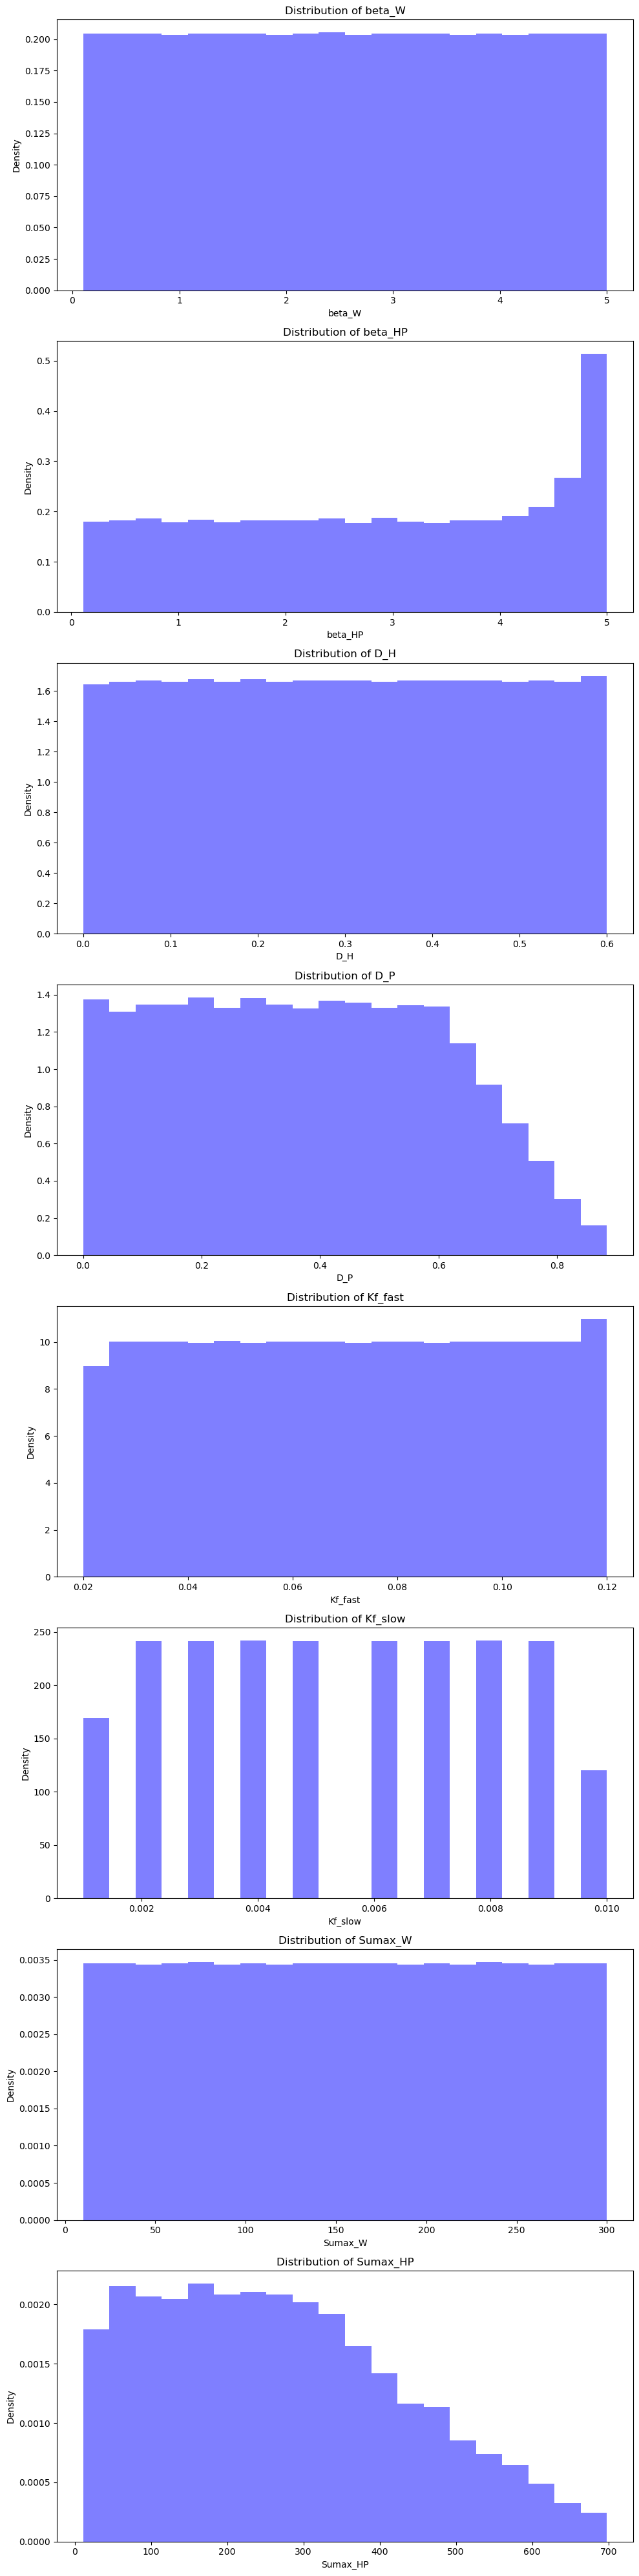

In [74]:
plot_parameter_distributions(samples, parameter_names)

In [84]:
# Sample size
n_full = 1024
n_typical = 256

# Generate custom samples

full_custom_samples = generate_custom_samples(full_range, n_full)
typical_custom_samples = generate_custom_samples(typical_range, n_typical)

combined_samples = full_custom_samples + typical_custom_samples

In [71]:
combined_samples_df =  pd.DataFrame(combined_samples)
print(combined_samples_df.tail())

      beta_W  beta_HP    D_H    D_P  Kf_fast  Kf_slow  Sumax_W  Sumax_HP
1275   1.855    0.889  0.208  0.254    0.043    0.008   80.884   211.455
1276   1.533    0.800  0.263  0.202    0.048    0.008   75.811   267.239
1277   0.564    1.030  0.199  0.240    0.051    0.005  122.929   241.912
1278   0.718    0.923  0.235  0.192    0.041    0.010  147.244   161.213
1279   1.382    0.819  0.151  0.229    0.058    0.007   94.032   343.882


In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parameter_distributions(samples, parameter_names):
    """
    Plots the distribution of each parameter using histograms.

    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to plot.
    """
    num_params = len(parameter_names)
    fig, axes = plt.subplots(num_params, 1, figsize=(10, 5 * num_params))
    
    if num_params == 1:
        axes = [axes]  # Make it iterable
    
    for ax, param in zip(axes, parameter_names):
        param_values = [sample[param] for sample in samples]
        ax.hist(param_values, bins=20, alpha=0.5, color='blue', density=True) #density = True?
        ax.set_title(f'Distribution of {param}')
        ax.set_xlabel(param)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()

In [9]:
def calculate_coefficient_of_variation(samples, parameter_names):
    """
    Calculates and prints the Coefficient of Variation (CV) for each parameter.
    
    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to calculate CV for.
    """
    for param in parameter_names:
        param_values = np.array([sample[param] for sample in samples])
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        cv = std_dev / mean if mean else 0  # Avoid division by zero
        print(f'Coefficient of Variation for {param}: {cv:.3f}')

In [10]:
calculate_coefficient_of_variation(full_custom_samples, parameter_names)
#calculate_coefficient_of_variation(typical_custom_samples, parameter_names)

Coefficient of Variation for beta_W: 0.555
Coefficient of Variation for beta_HP: 0.540
Coefficient of Variation for D_H: 0.577
Coefficient of Variation for D_P: 0.591
Coefficient of Variation for Kf_fast: 0.412
Coefficient of Variation for Kf_slow: 0.492
Coefficient of Variation for Sumax_W: 0.540
Coefficient of Variation for Sumax_HP: 0.611


# Run below only when you want to save the final outputs

In [10]:
import os
import pandas as pd

#os.chdir('/mnt/c/Workspace/Ch3/wflow_models/')
os.chdir('/mnt/d/wflow_models/')

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(combined_samples)

#print(df)
# Save the DataFrame to a CSV file
df.to_csv('combined_samples_v2.csv', index=False)

# OLD

In [ ]:
import numpy as np

def sample_parameters(defaults, range_constraints):
    params = {}
    for param, stats in defaults.items():
        mean, std = stats['mean'], stats['std']
        min_val, max_val = range_constraints[param]['min'], range_constraints[param]['max']
        
        # Sample within the specified range
        while True:
            sample = np.random.normal(mean, std)
            if min_val <= sample <= max_val:
                params[param] = sample
                break
    
    # Ensure relationships between parameters
    # This may need several iterations for all conditions to be satisfied
    satisfied = False
    while not satisfied:
        if params['beta_W'] > params['beta_HP']:
            params['beta_W'], params['beta_HP'] = np.random.normal(defaults['beta_W']['mean'], defaults['beta_W']['std']), np.random.normal(defaults['beta_HP']['mean'], defaults['beta_HP']['std'])
        
        if params['D_H'] >= params['D_P']:
            params['D_H'], params['D_P'] = np.random.normal(defaults['D_H']['mean'], defaults['D_H']['std']), np.random.normal(defaults['D_P']['mean'], defaults['D_P']['std'])
        
        if params['Kf_fast'] >= params['Kf_slow']:
            params['Kf_fast'], params['Kf_slow'] = np.random.normal(defaults['Kf_fast']['mean'], defaults['Kf_fast']['std']), np.random.normal(defaults['Kf_slow']['mean'], defaults['Kf_slow']['std'])
        
        if params['Sumax_W'] > params['Sumax_HP']:
            params['Sumax_W'], params['Sumax_HP'] = np.random.normal(defaults['Sumax_W']['mean'], defaults['Sumax_W']['std']), np.random.normal(defaults['Sumax_HP']['mean'], defaults['Sumax_HP']['std'])
        
        # Check if all relationships are satisfied
        satisfied = (params['beta_W'] <= params['beta_HP'] and
                     params['D_H'] < params['D_P'] and
                     params['Kf_fast'] < params['Kf_slow'] and
                     params['Sumax_W'] <= params['Sumax_HP'])
    
    return params

# Example usage
defaults = {
    'beta_W': {'mean': 0.27, 'std': 0.135},
    'beta_HP': {'mean': 0.27, 'std': 0.135},
    'D_H': {'mean': 0.24, 'std': 0.12},
    'D_P': {'mean': 0.24, 'std': 0.12},
    'Kf_fast': {'mean': 0.04, 'std': 0.02},
    'Kf_slow': {'mean': 0.005, 'std': 0.0025},
    'Sumax_W': {'mean': 100, 'std': 50},
    'Sumax_HP': {'mean': 250, 'std': 125}
}

range_constraints = {
    'beta_W': {'min': 0, 'max': 5},
    'beta_HP': {'min': 0, 'max': 5},
    'D_H': {'min': 0, 'max': 1},
    'D_P': {'min': 0, 'max': 1},
    'Kf_fast': {'min': 0.01, 'max': 0.08},
    'Kf_slow': {'min': 0.0008, 'max': 0.01},
    'Sumax_W': {'min': 5, 'max': 250},
    'Sumax_HP': {'min': 5, 'max': 500},
}

sample


2336410


/tmp/ipykernel_15557/1625775067.py:25: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
/tmp/ipykernel_15557/1625775067.py:26: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)


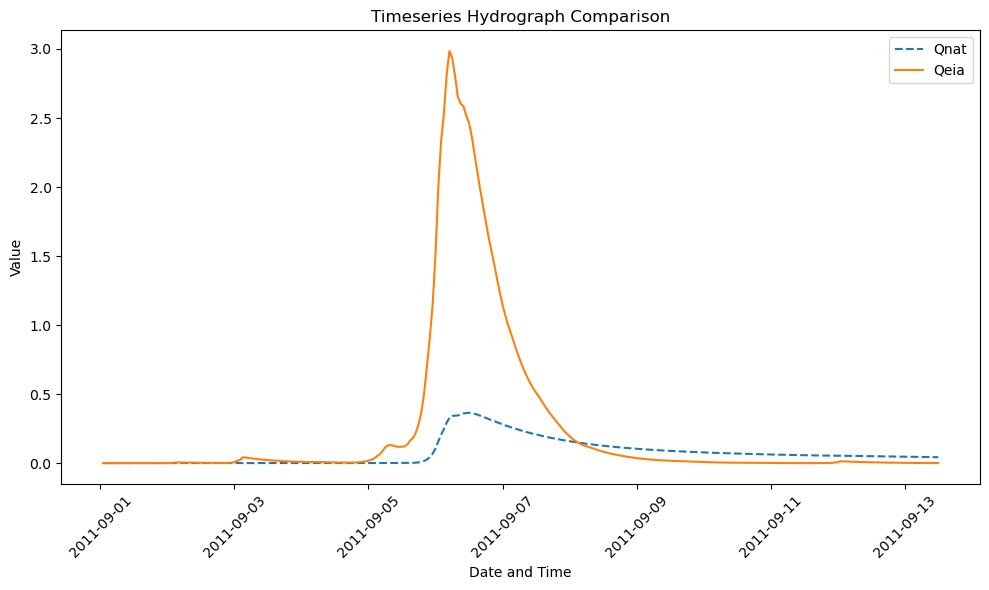

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


runId = "output/test_dt_Simp2"

outlet = str(int(wsName.split("_")[-1]))
print(outlet)

output_directory = str("../wflow_models/" +wsName + "/" + runId)

# Create a time series index
date_range = pd.date_range(start=datetimestart, periods=lastTimeStep + 1, freq=f'{timestepsecs}s')
date_range = date_range[:-1]

# Paths to the CSV files
#path0 = str(output_directory + '/Prec.csv')
path1 = str(output_directory + '/Qt.csv')
path2 = str(output_directory + '/Qeia.csv')



# Read the last column from both CSV files
df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)
#df3 = pd.read_csv(path3, usecols=['1401'], squeeze=True)
#df4 = pd.read_csv(path4, usecols=['1401'], squeeze=True)
#df5 = pd.read_csv(path5, usecols=['1401'], squeeze=True)
#df6 = pd.read_csv(path6, usecols=['1401'], squeeze=True)


# Assign the date_range as the index directly
df1.index = date_range
df2.index = date_range
#df3.index = date_range
#df4.index = date_range
#df5.index = date_range
#df6.index = date_range


# Ensure the lengths match, trimming if necessary (optional, remove if not needed)
df1 = df1.iloc[:len(date_range)]
df2 = df2.iloc[:len(date_range)]
#df3 = df3.iloc[:len(date_range)]
#df4 = df4.iloc[:len(date_range)]
#df5 = df5.iloc[:len(date_range)]
#df6 = df6.iloc[:len(date_range)]




# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1, label='Qnat', linestyle='--')
plt.plot(df2.index, df2, label='Qeia')
#plt.plot(df3.index, df3, label='BetaKf0Lumped', linestyle='--')
#plt.plot(df4.index, df4, label='Realistic', linestyle='--')
#plt.plot(df5.index, df5, label='None', linestyle='-.')
#plt.plot(df6.index, df6, label='BetaKf0Distributed', linestyle='-.')
plt.title('Timeseries Hydrograph Comparison')
plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
from pyDOE import lhs

# Define the number of samples
num_samples = 1000

# LHS sampling from a uniform distribution [0, 1) for each parameter (4 parameters in total)
uniform_samples = lhs(4, samples=num_samples)

# Default values and standard deviations for Gaussian transformation
defaults = {
    'beta': {'mean': 2.55, 'std': 1.275},  # Adjust mean and std according to your needs
    'D': {'mean': 0.5, 'std': 0.25},
    'Kf': {'mean': 0.0204, 'std': 0.01},
    'Sumax': {'mean': 350, 'std': 125},
}

# Parameter constraints (example values, adjust as needed)
constraints = {
    'beta_a': {'min': 0.1, 'max': 5},
    'D_b': {'min': 0, 'max': 1},
    'Kf_c': {'min': 0.0008, 'max': 0.04},
    'Sumax_d': {'min': 100, 'max': 600},
}

# Transform uniform LHS samples to Gaussian based on default values
gaussian_samples = np.zeros(uniform_samples.shape)
for i, (key, value) in enumerate(defaults.items()):
    gaussian_samples[:, i] = norm.ppf(uniform_samples[:, i], loc=value['mean'], scale=value['std'])

# Apply constraints (simple example, more complex logic might be required for your specific model)
# Ensure samples are within defined ranges
for i, (key, constraint) in enumerate(constraints.items()):
    gaussian_samples[:, i] = np.clip(gaussian_samples[:, i], constraint['min'], constraint['max'])

# For correlated parameters, like beta, enforce a = d < b = c through sorting or other logic
# This step is highly specific to your model's constraints and might need customization

# Example: Sorting the 'beta' and 'D' samples to enforce a simple constraint
# This is a placeholder step; replace with your specific constraints logic
gaussian_samples[:, [0, 1]] = np.sort(gaussian_samples[:, [0, 1]], axis=1)

# Output
print("Sample of transformed and constrained Gaussian LHS samples for each parameter:")
for i, param in enumerate(defaults.keys()):
    print(f"{param}: {gaussian_samples[:5, i]}")
